# MAT TO JSON LOADER

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy.io
from tqdm import tqdm

from IPython.display import clear_output

In [2]:
def convert_mat_to_json(input_path, output_path, subfolders=True):
    os.makedirs(output_path, exist_ok=True)

    def mat_to_dict(mat_obj):
        def _check_keys(obj):
            if isinstance(obj, scipy.io.matlab.mat_struct):
                return _todict(obj)
            elif isinstance(obj, np.ndarray):
                return [_check_keys(el) for el in obj]
            else:
                return obj

        def _todict(matobj):
            d = {}
            for fieldname in matobj._fieldnames:
                d[fieldname] = _check_keys(getattr(matobj, fieldname))
            return d

        return {key: _check_keys(val) for key, val in mat_obj.items() if not key.startswith("__")}

    files_found = False

    if subfolders:
        walker = os.walk(input_path)
    else:
        walker = [(input_path, [], os.listdir(input_path))]

    for root, _, files in walker:
        for file in files:
            if file.endswith(".mat"):
                files_found = True
                mat_path = os.path.join(root, file)
                battery_id = os.path.splitext(file)[0]

                try:
                    mat_data = scipy.io.loadmat(mat_path, struct_as_record=False, squeeze_me=True)
                    nested_dict = mat_to_dict(mat_data)

                    json_output_path = os.path.join(output_path, f"{battery_id}.json")
                    with open(json_output_path, "w") as f:
                        json.dump(nested_dict, f, indent=2, default=str)

                    print(f"Converted: {battery_id} -> {json_output_path}")

                except Exception as e:
                    print(f"Failed to convert {file}: {e}")

    if not files_found:
        print(f"No matching '.mat' files found in '{input_path}' (subfolders={subfolders}).")


In [3]:
def print_json_tree(obj, indent=0, max_depth=5):
    """Recursively print the structure of a JSON object."""
    prefix = "    " * indent
    if isinstance(obj, dict):
        for key, value in obj.items():
            print(f"{prefix}├── {key}")
            if indent < max_depth:
                print_json_tree(value, indent + 1, max_depth)
    elif isinstance(obj, list):
        print(f"{prefix}├── [list] ({len(obj)} items)")
        if len(obj) > 0 and indent < max_depth:
            print_json_tree(obj[0], indent + 1, max_depth)
    else:
        print(f"{prefix}├── {type(obj).__name__}")


In [4]:
# ==== Convert Nasa Dataset ====

convert_mat_to_json(
    input_path="../Datasets/5.+Battery+Data+Set/5. Battery Data Set",
    output_path="../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json",
    subfolders= True
)

# ==== Check Nasa Structure ====

clear_output(wait=True)
json_path = "../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json/B0005.json"
with open(json_path, "r") as f:
    json_data = json.load(f)

print("Sample Dataset Tree Structure:\n")
print_json_tree(json_data)

Sample Dataset Tree Structure:

├── B0005
    ├── cycle
        ├── [list] (616 items)
            ├── type
                ├── str
            ├── ambient_temperature
                ├── int
            ├── time
                ├── [list] (6 items)
                    ├── float
            ├── data
                ├── Voltage_measured
                    ├── [list] (789 items)
                ├── Current_measured
                    ├── [list] (789 items)
                ├── Temperature_measured
                    ├── [list] (789 items)
                ├── Current_charge
                    ├── [list] (789 items)
                ├── Voltage_charge
                    ├── [list] (789 items)
                ├── Time
                    ├── [list] (789 items)


In [5]:
# ==== Convert Oxford Dataset ====

convert_mat_to_json(
    input_path="../Datasets/Oxford Battery Degradation Dataset 1",
    output_path="../Datasets/Oxford Battery Degradation Dataset 1/json",
    subfolders= False
)

# ==== Check Oxford Structure ====

clear_output(wait=True)
json_path = "../Datasets/Oxford Battery Degradation Dataset 1/json/Oxford_Battery_Degradation_Dataset_1.json"
with open(json_path, "r") as f:
    json_data = json.load(f)

print("Sample Dataset Tree Structure:\n")
print_json_tree(json_data)


Sample Dataset Tree Structure:

├── Cell1
    ├── cyc0000
        ├── C1ch
            ├── t
                ├── [list] (3510 items)
                    ├── float
            ├── v
                ├── [list] (3510 items)
                    ├── float
            ├── q
                ├── [list] (3510 items)
                    ├── float
            ├── T
                ├── [list] (3510 items)
                    ├── float
        ├── C1dc
            ├── t
                ├── [list] (3608 items)
                    ├── float
            ├── v
                ├── [list] (3608 items)
                    ├── float
            ├── q
                ├── [list] (3608 items)
                    ├── float
            ├── T
                ├── [list] (3608 items)
                    ├── float
        ├── OCVch
            ├── t
                ├── [list] (12803 items)
                    ├── float
            ├── v
                ├── [list] (12803 items)
                    ├── float
        

# FEATURE ENGINEERING

In [6]:
# Engineering Features
# 1. Integration of current to compute charge (q) in Ah on NASA dataset to match Oxford dataset (only sample Oxford has i).
# 2. Match Capacity units to Ah for both datasets.
# 3. Fix time parsing in Oxford dataset.
# 4. Calculate capacity gap (q_gap) in Ah and percentage for NASA dataset (calculated Q vs Capacity).
# 5. Oxford dataset has no reported capacity, so we use the full discharge capacity as the computed capacity.
# 6. Add ambient temperature as a features for both datasets.


# ==== Shared Utilities ====

def compute_derivatives_over_time(values, time):
    if len(values) < 2 or len(values) != len(time):
        return None
    return np.gradient(values, time)

# ==== NASA DATASET FEATURE LOADER WITH q ====

def load_nasa_dataset_with_q_ah(path, initial_capacity=2.0, verbose=False):
    """
    Load NASA dataset and compute charge (q) in Ah using integration.
    Returns a DataFrame with features consistent with Oxford loader.
    Includes success/error logging for each file and cycle.
    """
    rows = []
    success_files = 0
    failed_files = 0
    failed_cycles = 0
    processed_cycles = 0

    for battery_file in tqdm(os.listdir(path), desc="Loading NASA dataset"):
        if not battery_file.endswith(".json"):
            continue

        battery_id = battery_file.split(".")[0]
        file_path = os.path.join(path, battery_file)

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            failed_files += 1
            if verbose:
                print(f"❌ Failed to load {battery_file}: {e}")
            continue

        battery_data = data.get(battery_id, {})
        cycles = battery_data.get("cycle", [])

        for idx, cycle in enumerate(cycles):
            if cycle.get("type") != "discharge": # only discharge cycles
                continue

            try:
                time = np.array(cycle["data"].get("Time", []))  # already in seconds
                current = np.array(cycle["data"].get("Current_measured", []))  # already in Amps
                voltage = np.array(cycle["data"].get("Voltage_measured", []))
                temp = np.array(cycle["data"].get("Temperature_measured", []))
                ambient_temp = cycle.get("ambient_temperature", None)

                if len(time) < 2 or not all(len(arr) == len(time) for arr in [current, voltage, temp]):
                    raise ValueError("Mismatched array lengths")

                sorted_indices = np.argsort(time)
                time = time[sorted_indices]
                current = current[sorted_indices]
                voltage = voltage[sorted_indices]
                temp = temp[sorted_indices]

                q_coulomb = np.trapz(current, time)
                q_ah = -q_coulomb / 3600  # in Ah (negative for discharge), flip polarity

                # Derivatives
                dq_dt = compute_derivatives_over_time(q_ah * 1000 * np.ones_like(time), time)
                dv_dt = compute_derivatives_over_time(voltage, time)
                dT_dt = compute_derivatives_over_time(temp, time)

                row = {
                    "battery_id": battery_id,
                    "cycle_idx": idx,
                    "rated_capacity": initial_capacity,
                    "ambient_temperature": ambient_temp,
                    "capacity": cycle["data"].get("Capacity", None),
                    "soh": (cycle["data"].get("Capacity", 0) or 0) / initial_capacity,
                    "computed_q_max_Ah": q_ah,
                    "capacity_reported_Ah": cycle["data"].get("Capacity", None),
                    "duration": time[-1] - time[0],
                    "q_gap_abs": q_ah - (cycle["data"].get("Capacity") or 0),
                    "q_gap_pct": 100 * (q_ah - (cycle["data"].get("Capacity") or 0)) / (cycle["data"].get("Capacity") or 1),
                    "dv_dt_mean": np.mean(dv_dt),
                    "dv_dt_std": np.std(dv_dt),
                    "dv_dt_max": np.max(dv_dt),
                    "dv_dt_min": np.min(dv_dt),
                    "dT_dt_mean": np.mean(dT_dt),
                    "dT_dt_std": np.std(dT_dt),
                    "dT_dt_max": np.max(dT_dt),
                    "dT_dt_min": np.min(dT_dt),
                    "dq_dt_mean": np.mean(dq_dt),
                    "dq_dt_std": np.std(dq_dt),
                    "dq_dt_max": np.max(dq_dt),
                    "dq_dt_min": np.min(dq_dt),
                    "test_condition": "nasa_room_ambient"
                }

                rows.append(row)
                processed_cycles += 1

            except Exception as e:
                failed_cycles += 1
                if verbose:
                    print(f"⚠️ Error in {battery_id} cycle {idx}: {e}")
                continue

        success_files += 1

    if verbose:
        print(f"\n✅ Successfully processed files: {success_files}")
        print(f"❌ Failed to load files: {failed_files}")
        print(f"✅ Cycles processed: {processed_cycles}")
        print(f"⚠️ Cycles failed: {failed_cycles}")

    return pd.DataFrame(rows)


# ==== OXFORD FEATURE LOADER ====

def load_oxford_q_summary(json_data, initial_capacity=0.74):
    """
    Load Oxford dataset and extract q(t) and time-derivative features including full metadata.
    Returns a DataFrame with features consistent with NASA loader.
    """
    rows = []

    for cell_id, cycles in tqdm(json_data.items(), desc="Loading Oxford cells"):
        for cyc_id, cycle in cycles.items():
            if "C1dc" not in cycle:
                continue  # Only discharge cycles

            c1dc = cycle["C1dc"]
            q = np.array(c1dc.get("q", []))
            t_raw = np.array(c1dc.get("t", []))  # MATLAB datenum format
            v = np.array(c1dc.get("v", []))
            T = np.array(c1dc.get("T", []))

            if len(q) < 2 or not all(len(arr) == len(t_raw) for arr in [q, v, T]):
                continue

            try:
                # ✅ Convert MATLAB datenum to seconds relative to cycle start
                t = (t_raw - t_raw[0]) * 86400  

                # Derivatives
                dv_dt = np.gradient(v, t)
                dT_dt = np.gradient(T, t)
                dq_dt = np.gradient(q, t)

                q_ah = abs(min(q)) / 1000  # in Ah, assume full discharge

                row = {
                    "battery_id": f"Oxford_{cell_id}",
                    "cycle_idx": int(cyc_id.replace("cyc", "")),
                    "rated_capacity": initial_capacity,
                    "ambient_temperature": 40,  # constant in Oxford
                    "capacity": q_ah,
                    "soh": q_ah / initial_capacity,
                    "computed_q_max_Ah": q_ah,
                    "capacity_reported_Ah": None,  # Oxford has no reported capacity
                    "duration": max(t) - min(t),
                    "q_gap_abs": 0,
                    "q_gap_pct": 0,
                    "dv_dt_mean": np.mean(dv_dt),
                    "dv_dt_std": np.std(dv_dt),
                    "dv_dt_max": np.max(dv_dt),
                    "dv_dt_min": np.min(dv_dt),
                    "dT_dt_mean": np.mean(dT_dt),
                    "dT_dt_std": np.std(dT_dt),
                    "dT_dt_max": np.max(dT_dt),
                    "dT_dt_min": np.min(dT_dt),
                    "dq_dt_mean": np.mean(dq_dt),
                    "dq_dt_std": np.std(dq_dt),
                    "dq_dt_max": np.max(dq_dt),
                    "dq_dt_min": np.min(dq_dt),
                    "test_condition": "oxford_40C_1C"
                }

                rows.append(row)

            except Exception as e:
                print(f"⚠️ Error processing {cell_id} {cyc_id}: {e}")
                continue

    return pd.DataFrame(rows)


# ==== OXFORD JSON LOADERS ====

def load_oxford_json_nested(folder_path):
    """
    Loads the Oxford JSON file and unpacks nested JSON string if needed.
    
    Returns:
        dict: parsed JSON dictionary with correct structure
    """
    for file in os.listdir(folder_path):
        if file.endswith(".json") and "Oxford" in file:
            path = os.path.join(folder_path, file)
            try:
                with open(path, "r") as f:
                    raw = json.load(f)
                if isinstance(raw, str):
                    data = json.loads(raw)  # second parse if it's a nested string
                else:
                    data = raw
                print(f"✅ Successfully loaded and parsed: {file}")
                return data
            except Exception as e:
                print(f"❌ Failed to load Oxford JSON: {e}")
                return None
    print("❌ No valid Oxford JSON found in the folder.")
    return None

In [7]:
nasa_path = "../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json"
nasa_df = load_nasa_dataset_with_q_ah(nasa_path, verbose=True)
nasa_df.head()

Loading NASA dataset: 100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


✅ Successfully processed files: 34
❌ Failed to load files: 0
✅ Cycles processed: 2794
⚠️ Cycles failed: 0


,battery_id,cycle_idx,rated_capacity,ambient_temperature,capacity,soh,computed_q_max_Ah,capacity_reported_Ah,duration,q_gap_abs,...,dv_dt_min,dT_dt_mean,dT_dt_std,dT_dt_max,dT_dt_min,dq_dt_mean,dq_dt_std,dq_dt_max,dq_dt_min,test_condition
0,B0005,1,2.0,24,1.856487,0.928244,1.862192,1.856487,3690.234,0.005705,...,-0.006445,0.002755,0.005795,0.011200,-0.016846,2.164090e-16,5.767974e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
1,B0005,3,2.0,24,1.846327,0.923164,1.851986,1.846327,3672.344,0.005658,...,-0.007408,0.002709,0.005664,0.010492,-0.016217,-4.712783e-16,4.976330e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
2,B0005,5,2.0,24,1.835349,0.917675,1.840993,1.835349,3651.641,0.005644,...,-0.006764,0.002669,0.005607,0.010571,-0.016199,1.457524e-16,5.799726e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
3,B0005,7,2.0,24,1.835263,0.917631,1.840881,1.835263,3631.563,0.005618,...,-0.007604,0.002744,0.005538,0.010650,-0.016200,7.325183e-17,5.904843e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
4,B0005,9,2.0,24,1.834646,0.917323,1.840325,1.834646,3629.172,0.005680,...,-0.008324,0.002759,0.005523,0.010878,-0.015967,1.465037e-16,5.990997e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient


In [8]:
oxford_path = "../Datasets/Oxford Battery Degradation Dataset 1/json"
oxford_json = load_oxford_json_nested(oxford_path)
if oxford_json:
    oxford_df = load_oxford_q_summary(oxford_json)
oxford_df.head()

✅ Successfully loaded and parsed: Oxford_Battery_Degradation_Dataset_1.json


Loading Oxford cells: 100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


,battery_id,cycle_idx,rated_capacity,ambient_temperature,capacity,soh,computed_q_max_Ah,capacity_reported_Ah,duration,q_gap_abs,...,dv_dt_min,dT_dt_mean,dT_dt_std,dT_dt_max,dT_dt_min,dq_dt_mean,dq_dt_std,dq_dt_max,dq_dt_min,test_condition
0,Oxford_Cell1,0,0.74,40,0.739111,0.998799,0.739111,None,3606.330147,0,...,-0.015480,0.000298,0.025866,0.113391,-0.087363,-0.204947,0.000190,-0.194832,-0.204965,oxford_40C_1C
1,Oxford_Cell1,100,0.74,40,0.730193,0.986747,0.730193,None,3563.544049,0,...,-0.016161,0.000172,0.025882,0.099868,-0.136606,-0.204905,0.000194,-0.194814,-0.204949,oxford_40C_1C
2,Oxford_Cell1,200,0.74,40,0.725747,0.980739,0.725747,None,3542.140735,0,...,-0.015961,0.000032,0.027449,0.087362,-0.428081,-0.204888,0.000192,-0.194795,-0.204939,oxford_40C_1C
3,Oxford_Cell1,300,0.74,40,0.722843,0.976815,0.722843,None,3528.063764,0,...,-0.016969,-0.000404,0.037050,0.099848,-1.173595,-0.204882,0.000192,-0.194722,-0.204898,oxford_40C_1C
4,Oxford_Cell1,400,0.74,40,0.718367,0.970766,0.718367,None,3505.889715,0,...,-0.016000,0.000263,0.025869,0.087381,-0.093615,-0.204901,0.000193,-0.194788,-0.204932,oxford_40C_1C


In [14]:
# ==== MERGE DATASETS ====
df_all = pd.concat([nasa_df, oxford_df], ignore_index=True)

# Attempt to convert object columns to numeric where possible
obj_cols = df_all.select_dtypes(include='object').columns
for col in obj_cols:
    try:
        df_all[col] = pd.to_numeric(df_all[col])
    except:
        pass  # leave column as is if conversion fails

# Force known numeric-like columns
df_all['capacity'] = pd.to_numeric(df_all['capacity'], errors='coerce')
df_all['capacity_reported_Ah'] = pd.to_numeric(df_all['capacity_reported_Ah'], errors='coerce')

df_all.to_csv("merged_battery_dataset.csv", index=False)
print("✅ Merged dataset saved as 'merged_battery_dataset.csv'")
df_all.head()


✅ Merged dataset saved as 'merged_battery_dataset.csv'


,battery_id,cycle_idx,rated_capacity,ambient_temperature,capacity,soh,computed_q_max_Ah,capacity_reported_Ah,duration,q_gap_abs,...,dv_dt_min,dT_dt_mean,dT_dt_std,dT_dt_max,dT_dt_min,dq_dt_mean,dq_dt_std,dq_dt_max,dq_dt_min,test_condition
0,B0005,1,2.0,24,1.856487,0.928244,1.862192,1.856487,3690.234,0.005705,...,-0.006445,0.002755,0.005795,0.011200,-0.016846,2.164090e-16,5.767974e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
1,B0005,3,2.0,24,1.846327,0.923164,1.851986,1.846327,3672.344,0.005658,...,-0.007408,0.002709,0.005664,0.010492,-0.016217,-4.712783e-16,4.976330e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
2,B0005,5,2.0,24,1.835349,0.917675,1.840993,1.835349,3651.641,0.005644,...,-0.006764,0.002669,0.005607,0.010571,-0.016199,1.457524e-16,5.799726e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
3,B0005,7,2.0,24,1.835263,0.917631,1.840881,1.835263,3631.563,0.005618,...,-0.007604,0.002744,0.005538,0.010650,-0.016200,7.325183e-17,5.904843e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient
4,B0005,9,2.0,24,1.834646,0.917323,1.840325,1.834646,3629.172,0.005680,...,-0.008324,0.002759,0.005523,0.010878,-0.015967,1.465037e-16,5.990997e-15,1.421085e-14,-1.421085e-14,nasa_room_ambient


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   battery_id            3313 non-null   object 
 1   cycle_idx             3313 non-null   int64  
 2   rated_capacity        3313 non-null   float64
 3   ambient_temperature   3313 non-null   int64  
 4   capacity              3288 non-null   float64
 5   soh                   3313 non-null   float64
 6   computed_q_max_Ah     3313 non-null   float64
 7   capacity_reported_Ah  2769 non-null   float64
 8   duration              3313 non-null   float64
 9   q_gap_abs             3313 non-null   float64
 10  q_gap_pct             3313 non-null   float64
 11  dv_dt_mean            3313 non-null   float64
 12  dv_dt_std             3313 non-null   float64
 13  dv_dt_max             3313 non-null   float64
 14  dv_dt_min             3313 non-null   float64
 15  dT_dt_mean           

# MODEL TRAINING
Run this section for model training only

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
df_all_from_csv = pd.read_csv("merged_battery_dataset.csv")

# ==== Drop directly unused features ====
df_all_from_csv = df_all_from_csv.drop(columns=[
    'battery_id',
    'soh',
    'computed_q_max_Ah',
    'capacity_reported_Ah',
    'q_gap_abs',
    'q_gap_pct',
    'test_condition'
])

# Drop rows with any remaining NaNs
df_all_from_csv = df_all_from_csv.dropna()

df_all_from_csv.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3288 entries, 0 to 3312
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cycle_idx            3288 non-null   int64  
 1   rated_capacity       3288 non-null   float64
 2   ambient_temperature  3288 non-null   int64  
 3   capacity             3288 non-null   float64
 4   duration             3288 non-null   float64
 5   dv_dt_mean           3288 non-null   float64
 6   dv_dt_std            3288 non-null   float64
 7   dv_dt_max            3288 non-null   float64
 8   dv_dt_min            3288 non-null   float64
 9   dT_dt_mean           3288 non-null   float64
 10  dT_dt_std            3288 non-null   float64
 11  dT_dt_max            3288 non-null   float64
 12  dT_dt_min            3288 non-null   float64
 13  dq_dt_mean           3288 non-null   float64
 14  dq_dt_std            3288 non-null   float64
 15  dq_dt_max            3288 non-null   float6

In [19]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# =================== MODELS ===================
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class FCNN_Dropout(nn.Module):
    def __init__(self, input_dim):
        super(FCNN_Dropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class FCNN_BatchNorm(nn.Module):
    def __init__(self, input_dim):
        super(FCNN_BatchNorm, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])

# =================== TRAIN FUNCTION ===================
def train_model_cv(df_all, model_class, target_col='capacity', epochs=50, batch_size=32, lr=0.001, folds=5):
    X = df_all.drop(columns=[target_col])
    y = df_all[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    all_train_mse, all_val_mse = [], []
    all_train_mae, all_val_mae = [], []
    all_train_r2, all_val_r2 = [], []
    infer_times = []

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    for train_idx, val_idx in tqdm(kf.split(X_scaled), total=folds, desc="Folds"):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if isinstance(model_class, type) and issubclass(model_class, nn.Module):
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

            train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
            model = model_class(input_dim=X_train.shape[1])
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            train_mse, val_mse = [], []
            train_mae, val_mae = [], []
            train_r2, val_r2 = [], []

            for _ in tqdm(range(epochs), desc="Epochs", leave=False):
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    loss = criterion(model(X_batch), y_batch)
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    train_preds = model(X_train_tensor).numpy().flatten()
                    start_time = time.time()
                    val_preds = model(X_val_tensor).numpy().flatten()
                    infer_times.append(time.time() - start_time)
                    train_true = y_train_tensor.numpy().flatten()
                    val_true = y_val_tensor.numpy().flatten()

                    train_mse.append(mean_squared_error(train_true, train_preds))
                    val_mse.append(mean_squared_error(val_true, val_preds))
                    train_mae.append(mean_absolute_error(train_true, train_preds))
                    val_mae.append(mean_absolute_error(val_true, val_preds))
                    train_r2.append(r2_score(train_true, train_preds))
                    val_r2.append(r2_score(val_true, val_preds))

            all_train_mse.append(train_mse)
            all_val_mse.append(val_mse)
            all_train_mae.append(train_mae)
            all_val_mae.append(val_mae)
            all_train_r2.append(train_r2)
            all_val_r2.append(val_r2)

        else:
            model = model_class()
            model.fit(X_train, y_train)
            train_preds = model.predict(X_train)
            start_time = time.time()
            val_preds = model.predict(X_val)
            infer_times.append(time.time() - start_time)

            train_mse = [mean_squared_error(y_train, train_preds)] * epochs
            val_mse = [mean_squared_error(y_val, val_preds)] * epochs
            train_mae = [mean_absolute_error(y_train, train_preds)] * epochs
            val_mae = [mean_absolute_error(y_val, val_preds)] * epochs
            train_r2 = [r2_score(y_train, train_preds)] * epochs
            val_r2 = [r2_score(y_val, val_preds)] * epochs

            all_train_mse.append(train_mse)
            all_val_mse.append(val_mse)
            all_train_mae.append(train_mae)
            all_val_mae.append(val_mae)
            all_train_r2.append(train_r2)
            all_val_r2.append(val_r2)

    return {
        'train_mse': np.mean(all_train_mse, axis=0),
        'val_mse': np.mean(all_val_mse, axis=0),
        'train_mae': np.mean(all_train_mae, axis=0),
        'val_mae': np.mean(all_val_mae, axis=0),
        'train_r2': np.mean(all_train_r2, axis=0),
        'val_r2': np.mean(all_val_r2, axis=0),
        'infer_time': np.mean(infer_times)
    }

# =================== COMPARISON FUNCTION ===================
def compare_models(df_all, models_dict, metrics_to_plot=['mse', 'mae', 'r2']):
    results = {}
    summary_rows = []

    for name, model_class in models_dict.items():
        print(f"\n🚀 Training {name}...")
        res = train_model_cv(df_all, model_class)
        results[name] = res
        summary_rows.append({
            'Model': name,
            'Train MSE': np.mean(res['train_mse']),
            'Val MSE': np.mean(res['val_mse']),
            'Train MAE': np.mean(res['train_mae']),
            'Val MAE': np.mean(res['val_mae']),
            'Train R2': np.mean(res['train_r2']),
            'Val R2': np.mean(res['val_r2']),
            'Val Infer Time (s)': res['infer_time']
        })

    df_summary = pd.DataFrame(summary_rows)
    print("\n📊 Summary Table:")
    print(df_summary.to_string(index=False))

    num_models = len(models_dict)
    num_metrics = len(metrics_to_plot)
    fig, axs = plt.subplots(num_models, num_metrics, figsize=(5 * num_metrics, 4 * num_models), squeeze=False)

    for row_idx, (model_name, metrics) in enumerate(results.items()):
        for col_idx, metric in enumerate(metrics_to_plot):
            ax = axs[row_idx][col_idx]
            ax.plot(metrics[f'train_{metric}'], label='Train')
            ax.plot(metrics[f'val_{metric}'], label='Validation')
            ax.set_title(f"{model_name} - {metric.upper()}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(metric.upper())
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    return results


🚀 Training RandomForest...


Folds: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]



🚀 Training XGBoost...


Folds: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]



🚀 Training SVM...


Folds: 100%|██████████| 5/5 [00:00<00:00,  7.18it/s]



🚀 Training FCNN...


Folds: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]



🚀 Training FCNN_Dropout...


Folds: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]



🚀 Training FCNN_BatchNorm...


Folds: 100%|██████████| 5/5 [00:33<00:00,  6.72s/it]



🚀 Training LSTM...


Folds: 100%|██████████| 5/5 [00:35<00:00,  7.04s/it]



🚀 Training GRU...


Folds: 100%|██████████| 5/5 [00:32<00:00,  6.59s/it]



🚀 Training Transformer...


Folds: 100%|██████████| 5/5 [01:31<00:00, 18.30s/it]



📊 Summary Table:
         Model  Train MSE  Val MSE  Train MAE  Val MAE  Train R2   Val R2  Val Infer Time (s)
  RandomForest   0.001024 0.006568   0.008512 0.022313  0.995929 0.973848            0.018087
       XGBoost   0.000023 0.005606   0.003415 0.023111  0.999908 0.977620            0.000400
           SVM   0.012095 0.013135   0.074635 0.076579  0.951900 0.947683            0.014518
          FCNN   0.010661 0.019238   0.053215 0.057197  0.957622 0.924176            0.000159
  FCNN_Dropout   0.019118 0.020776   0.085584 0.087043  0.923979 0.917517            0.000196
FCNN_BatchNorm   0.018540 0.030047   0.072392 0.076097  0.926304 0.881906            0.000184
          LSTM   0.019240 0.021025   0.079472 0.082117  0.923494 0.916406            0.000655
           GRU   0.020555 0.021951   0.086447 0.088847  0.918269 0.912657            0.000573
   Transformer   0.006611 0.007719   0.056733 0.058864  0.973719 0.969239            0.002814


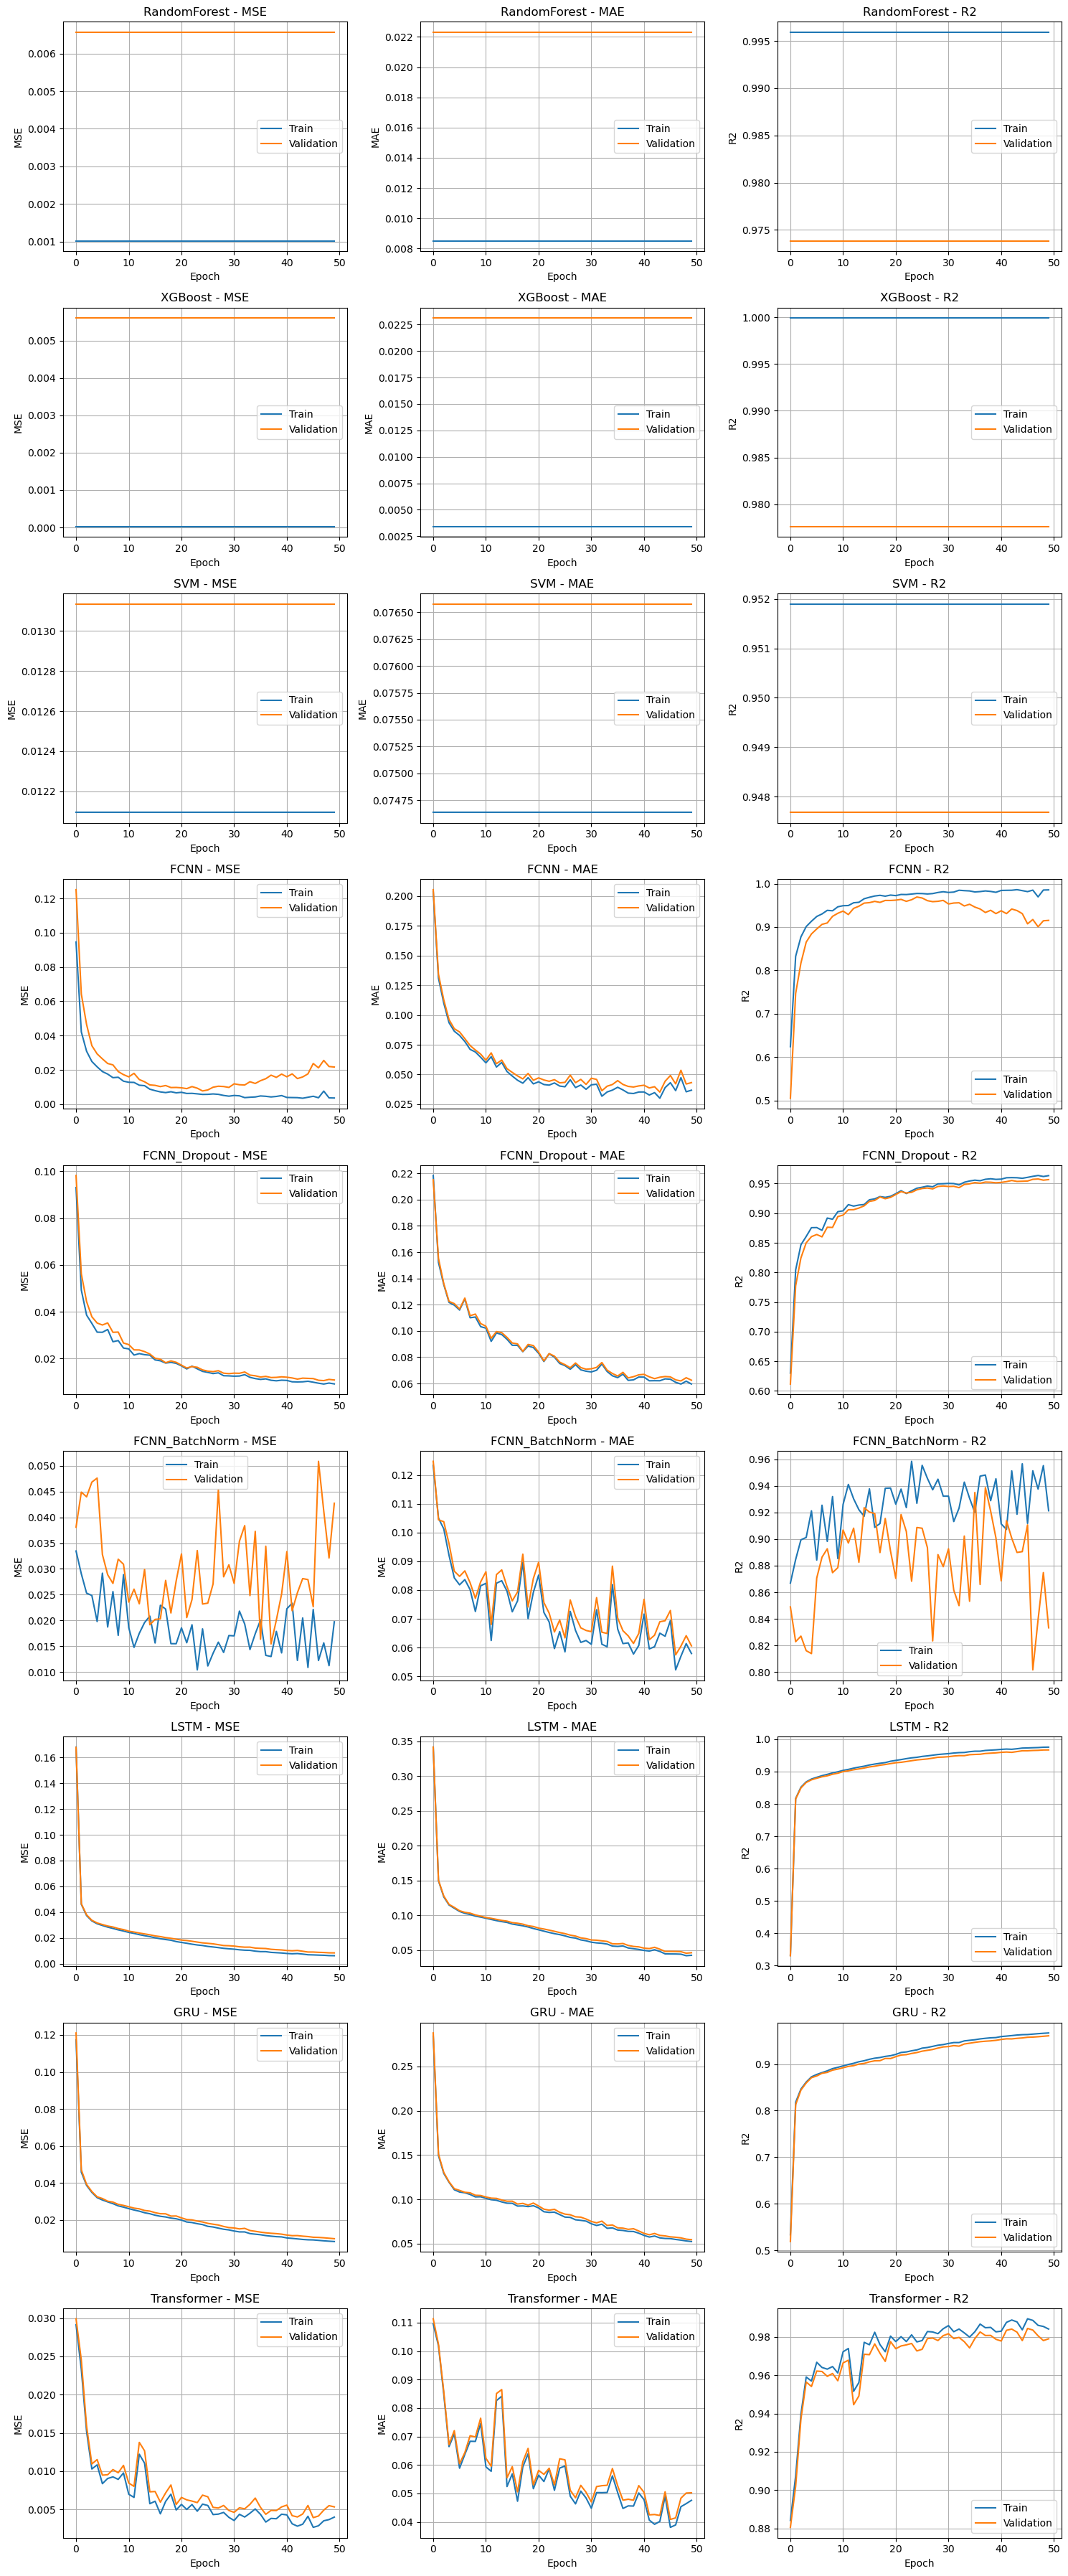

In [21]:
models_to_test = {
    'RandomForest': RandomForestRegressor,
    'XGBoost': XGBRegressor,
    'SVM': SVR,
    'FCNN': FCNN,
    'FCNN_Dropout': FCNN_Dropout,
    'FCNN_BatchNorm': FCNN_BatchNorm,
    'LSTM': LSTMModel,
    'GRU': GRUModel,
    'Transformer': SimpleTransformer,
}

results = compare_models(df_all_from_csv, models_to_test, metrics_to_plot=['mse', 'mae', 'r2'])